# Add Folders to Path

We start by adding the necessary folders to the current working path.

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add TRA folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/TRA")

# add ActiveBarriers folder to current working path
sys.path.append(parent_directory+"/demos/ActiveBarriers")

Wall time: 0 ns


# Overview

We illustrate the numerical implementation and the use of the active Trajectory Rotation Angle (aTRA) on 2-D homogeneous, isotropic turbulence. The active LCS diagnostic is applied to the two-dimensional and steady Lagrangian linear momentum barrier equation. The notebook is structured as follows:

1. Import vorticity and velocity data stored in the folder 'data/Turbulence'. Make sure that all the necessary files are stored in the folder 'data/Turbulence'.
<br />
2. Define computational parameters (such as the number of cores) and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data.
 <br />
5. Apply active Trajectory Rotation Average (aTRA) to Lagrangian linear momentum barrier equation:

   <br />
   
   * For 2D incompressible, uniform-density Navier–Stokes flows, the Lagrangian barrier equation for linear momentum is an autonomous Hamiltonian system of the form:
    
    \begin{equation}
    \mathbf{x}'=\nu \rho \mathbf{J} \mathbf{\nabla_0 \overline{\omega (\mathbf{F_{t_0}^{t}(x_0)}, t)}}
    \label{eq: linearmoment}
    \end{equation}
    
    Time 't' is just a fixed parameter and hence the system is autonomous and the integration is done with respect to a dummy time variable 's'. 's' can be arbitrarily large and the aTRA is only limited by the spatial resolution and domain.
    
    <br />
    
   * First we compute the trajectories over the time-interval [0, 25] over the selected domain. We then compute the right-hand-side of equation \ref{eq: linearmoment} by interpolating $ \mathbf{J} \mathbf{\nabla_0 \overline{\omega (\mathbf{F_{t_0}^{t}(x_0)}, t)}} $, where $ \overline{(\ldots)} $ denotes a temporal average.
   
   <br />
   
   * We then apply the aTRA to the autonomous ODE from equation \ref{eq: linearmoment} over different 'dummy' time-intervals.

# Import Data

In [2]:
%%time
# import scipy
import scipy.io

# import numpy
import numpy as np

# load vorticity data
turb_w = parent_directory + r'/data/Turbulence/turb_w'

omega = np.zeros((1024, 1024, 251))

# iterate over all files in folder 'turb_w' and load vorticity data
i = 0
for filename in sorted(os.listdir(turb_w)):
    if filename.endswith(".mat"):
        file_w = os.path.join(turb_w, filename)
        mat_turb_w = scipy.io.loadmat(file_w)
        omega[:,:,i] = mat_turb_w['w']
        i+=1

# load velocity data
turb_u = parent_directory + r'/data/Turbulence/turb_u'
      
# iterate over all files in folder 'turb_u' and load velocity data
i = 0
U = np.zeros((1024, 1024, 251))
V = np.zeros((1024, 1024, 251))
for filename in sorted(os.listdir(turb_u)):
    if filename.endswith(".mat"):
        file_u = os.path.join(turb_u, filename)
        mat_turb_u = scipy.io.loadmat(file_u)
        U[:,:,i] = mat_turb_u['u1']
        V[:,:,i] = mat_turb_u['u2']
        i+=1

# load x/y grid
X = scipy.io.loadmat(parent_directory + r'/data/Turbulence/grid.mat')['x']
Y = X.copy().transpose()

Wall time: 46.1 s


# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# Number of cores for parallel computing
Ncores = 4

# time-interval over which data is defined. DO NOT CHANGE!!!
time_data = np.linspace(0, 50, 251, endpoint = True).reshape(1, -1)

# time resolution of data
dt_data = time_data[0,1]-time_data[0,0]

# periodic boundary conditions
periodic_x = True
periodic_y = True
periodic_t = False
periodic = [periodic_x, periodic_y, periodic_t]

# unsteady velocity field
bool_unsteady = True

# defined domain
# This array denotes where the velocity field is defined (=1) and where it is not defined (=0)
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
%%time
# Initial time (in days)
t0 = 0

# Final time (in days)
tN = 25

# time step-size
dt = .2

# Time resolution: N = len(time)
time = np.arange(t0, tN+dt, dt)

# length of time interval (in days)
lenT = tN-t0

# domain boundary (in degrees)
xmin = 3
xmax = 5
ymin = 1
ymax = 3

# make sure that the spatio-temporal you defined are within the domain of the data
assert (xmax <= np.max(X) and xmin >= np.min(X) and ymin >= np.min(Y) and ymax <= np.max(Y) and t0 >= np.min(time_data) and tN <= np.max(time_data)),"The domains you are chooising are outside the domain of the data!!!!! --> redefine spatial/temporal domain"

# spacing of meshgrid (in degrees)
dx = 0.005
dy = 0.005

# NOTE: As we are computing spatial derivatives of the CG-tensor, the spacing of the meshgrid has to be sufficiently small.
# However, choosing dx to be too small leads to (unnecessary) long computation times.

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

# define dummy time interval
ds = 0.0025
sN = 0.25 # Feel free to change this parameter as needed
s_dummy = np.arange(0, sN+ds, ds)

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .2 # [1/5, 1/100]
aux_grid = [aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0])]

Wall time: 5.98 ms


# Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". Default value is "cubic".

In [5]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# set nan values to zero so that we can apply interpolant. Interpolant does not work if the array contains nan values
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, method = "cubic")

Interpolant_u = Interpolant[0]
Interpolant_v = Interpolant[1]

Wall time: 45.7 s


# Compute trajectories

In [6]:
%%time
# Import gradient of flow map
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import package which computes flow map
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# vectorize initial conditions by arranging them to a vector of size (Nx*Ny, 2)
x0 = X_domain.ravel()
y0 = Y_domain.ravel()

# split x0, y0 into 'Ncores' (equal) batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

x0_batch = list(split(x0, Ncores))
y0_batch = list(split(y0, Ncores))

def parallel_Fmap(x0_batch, y0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch])
    
    Fmap = integration_dFdt(time, X0, X, Y, Interpolant_u, Interpolant_v, periodic, bool_unsteady, time_data)[0]
    
    return Fmap

results = Parallel(n_jobs=Ncores, verbose = 50)(delayed(parallel_Fmap)(x0_batch[i], y0_batch[i]) for i in tqdm(range(len(x0_batch))))

Fmap = results[0]

for res in results[1:]:
    Fmap = np.append(Fmap, res, axis = 2)

  0%|          | 0/4 [00:00<?, ?it/s]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   47.8s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   50.5s remaining:   50.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   56.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   56.2s finished
Wall time: 58.1 s


# Lagrangian linear momentum barriers

We visualize linear momentum barriers by applying the TRA to trajectories of system \ref{eq: linearmoment}. As soon as the TRA is applied to an active vector field, such as linear momentum, we refer to it as aTRA (active TRA). We will subsequently compare the results with the classic version of the TRA-field.

## Interpolate Lagrangian momentum barrier field

We start by computing the interpolant for the instantaneous momentum barrier field. The interpolant is given by the right-hand-side of equation \ref{eq: linearmoment}.

In [7]:
%%time
# Import interpolation function for instantaneous active momentum barrier equation
from ipynb.fs.defs.LagrangianActiveMomentum import LagrangianActiveMomentum

# Interpolate RHS of linear momentum barrier equation using cubic spatial interpolation
Interpolant_momentum = LagrangianActiveMomentum(X_domain, Y_domain, X, Y, omega, Fmap, time, dt_data, aux_grid)

  0%|          | 0/251 [00:00<?, ?it/s]

Wall time: 39.7 s


## Compute trajectories from barrier equation

In the following we compute trajectories over a meshgrid. The integration is vectorized by arranging the initial conditions to a vector. As we need to compute the gradient of the flow map, we seed around each initial condition four particles on an auxiliary meshgrid. For each initial condition we hence have in total 5 particle trajectories (four auxiliary trajectories+original trajectory).

In [8]:
%%time
# Import gradient of flow map
from ipynb.fs.defs.RK4_integration import RK4_integration

# Import package which computes eigenvalues/eigenvectors
from ipynb.fs.defs.eigen import eigen

# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# initial conditions of auxiliary grid
x0_init, y0_init = X_domain.ravel(), Y_domain.ravel()

# create array which stores solution of particle trajectories
solODE = np.zeros((len(s_dummy), 2, len(x0_init)))

# create array which stores velocity of particle trajectories
solODE_velocity = np.zeros((len(s_dummy)-1, 2, len(x0_init)))
        
Interpolant_momentum_x = Interpolant_momentum[0]
Interpolant_momentum_y = Interpolant_momentum[1]
ds = s_dummy[1]-s_dummy[0]

# initial conditions of auxiliary grid
r0 = np.array([x0_init, y0_init]) # shape (len(x0_init), 2)

# solODE stores velocity along trajectories
solODE[0,:,:] = r0
    
# iterate over dummy time (compute trajectories)
for i in tqdm(range(len(s_dummy)-1)):
    solODE[i+1,:,:], solODE_velocity[i,:,:] = RK4_integration(solODE[i,:,:], ds, Interpolant_momentum[0], Interpolant_momentum[1])

  0%|          | 0/100 [00:00<?, ?it/s]

Wall time: 35.1 s


## Compute active TRA

We now compute the aTRA for the trajectories resulting from the Lagrangian linear momentum barrier equations \ref{eq: linearmoment}.

In [9]:
# Import package for computing Trajectory-Rotation-Angle (TRA)
from ipynb.fs.defs.TRA import _TRA

s = [0.05, 0.15, 0.25]
assert s[-1] <= np.max(s_dummy)

# compute aTRA
aTRA = [[], [], []]

for i in tqdm(range(solODE.shape[2])):
    
    counter = 0
    for idx in np.searchsorted(s_dummy, s):

        # aTRA
        aTRA[counter].append(_TRA(s_dummy[idx], solODE_velocity[:idx+1,:, i]))
        
        counter += 1

  0%|          | 0/160801 [00:00<?, ?it/s]

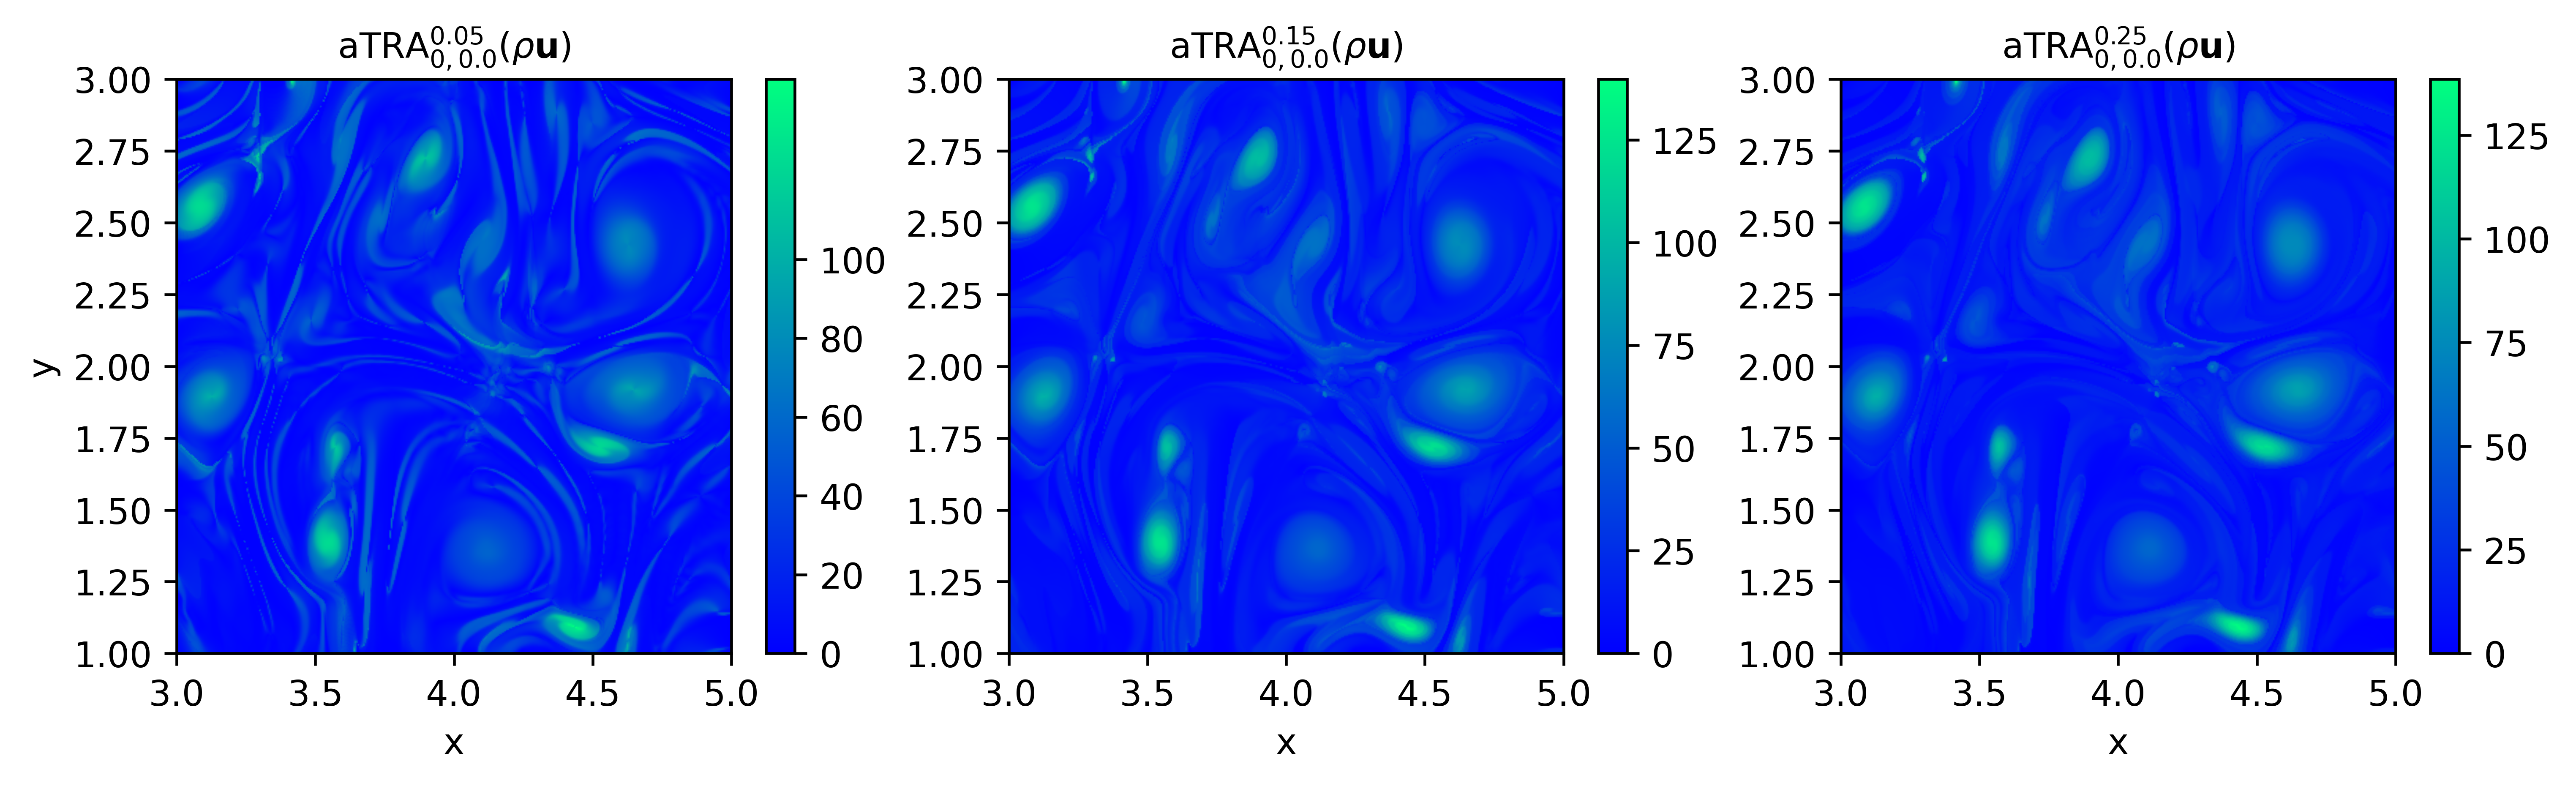

In [11]:
################################################ PLOT RESULTS ################################################

# Import plotting library
import matplotlib.pyplot as plt

# Figure/Axis
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, dpi = 600, figsize=(12, 3))

# Contourplot of aTRA_0^0.05 over meshgrid of initial conditions
cax = ax0.tricontourf(x0_init, y0_init, aTRA[0], cmap = "winter", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax0, ticks = np.linspace(0, 100, 6))

# Contourplot of aTRA_0^0.15 over meshgrid of initial conditions
cax = ax1.tricontourf(x0_init, y0_init, aTRA[1], cmap = "winter", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax1, ticks = np.linspace(0, 125, 6))

# Contourplot of aTRA_0^0.25 over meshgrid of initial conditions
cax = ax2.tricontourf(x0_init, y0_init, aTRA[2], cmap = "winter", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax2, ticks = np.linspace(0, 125, 6))

# Axis Labels
ax2.set_xlabel("x", fontsize = 10)
ax0.set_xlabel("x", fontsize = 10)
ax0.set_ylabel("y", fontsize = 10)
ax1.set_xlabel("x", fontsize = 10)

ax0.set_title(r'$ \mathrm{aTRA}$'+f'$_{{0,{np.around(s_dummy[0], 2)}}}^{{{np.around(s_dummy[np.searchsorted(s_dummy, s[0])], 2)}}}$'+r'($\rho \mathbf{u}$)', fontsize = 10)
ax1.set_title(r'$ \mathrm{aTRA}$'+f'$_{{0,{np.around(s_dummy[0], 2)}}}^{{{np.around(s_dummy[np.searchsorted(s_dummy, s[1])], 2)}}}$'+r'($\rho \mathbf{u}$)', fontsize = 10)
ax2.set_title(r'$ \mathrm{aTRA}$'+f'$_{{0,{np.around(s_dummy[0], 2)}}}^{{{np.around(s_dummy[np.searchsorted(s_dummy, s[2])], 2)}}}$'+r'($\rho \mathbf{u}$)', fontsize = 10)

plt.show()

The figures focus on momentum-based active barriers in one of the vortical regions of the two-dimensional turbulence model. 
The aTRA provides a clear picture the main vortex. The features become even more pronounced for longer s-times, revealing several secondary vortices around its neighbourhood.

# References

[1] Haller, G., Katsanoulis, S., Holzner, M., Frohnapfel, B., & Gatti, D. (2020). Objective barriers to the transport of dynamically active vector fields. Journal of Fluid Mechanics, 905.